# Odovzdanie 3 - Strojové učenie 
#### Anton Rusňák, František Gič

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 100)
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder 
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

## Predspracovanie nového datasetu nami realizovaným postupom predspracovania a opis prípadných zmien
Predspracovanie nového datasetu sme realizovali vytvorením python skriptu so všetkými funkciami z minulého odvzdávania. Tieto funkcie sme následne vložili poľa funkcíí a spustili nad jednotlivými datasetmi. Všetky funkcie taktiež využívajú parameter, dictionary, a pri fitovaní alebo iných dátach ktoré treba uložiť, okontrolujú či daný key existuje v dictionary (Ak existuje, znamená to že celá "pipeline" bola spustená minima lne raz, a data su uz ulozene, ak nie, tak data ulozi do dictionary).

Tuto funkciu sme spustili nad oboma datasetmi. Kedze sme nemali tuto funkcionalitu v predchadzajucom predspracovani, bolo nutne spravit mnozstvo zmien a refactornut kod aby hlavne prijmal cely dataset, kedze doteraz pouzival len map a apply nad jednotlivymi columnami. Taktiez sme zaintegrovali riesenie s dictionary.

In [2]:
%run "functions.py"

In [3]:
datastore = dict()

In [4]:
def repair_data(filename):
    
    data_personal = load("data/personal_"+filename+".csv")
    data_other = load("data/other_"+filename+".csv")
    data = pd.merge(data_personal,data_other,on=['name','address'], how = 'outer')
    
    functions = [
        sanitize_sex,
        sanitize_pregnancy,
        sanitize_personal_info,
        sanitize_age_of_birth,
        sanitize_age,
        sanitize_income,
        sanitize_string_attrs,
        deduplicate,
        predicate_kurt_oxygen,
        fill_null_age_by_mean,
        fill_education_values,
        fill_employment_values,
        fill_skewness_glucose,
        fill_pregnancy,
        fill_relationship_info,
        fill_mean_or_most_freq,
        resolve_outliers,
    ]
    
    for fn in functions:
        data = fn(data,datastore)
        
    return data

In [5]:
%%capture --no-display
data_train = repair_data("train")
data_valid = repair_data("valid")

## Manuálne vytvorenie a vyhodnotenie rozhodovacích pravidiel pre klasifikáciu

### **Pravidlo #1: (zahŕňajúce jeden atribút)**
Ak je hodnota atributu kurtosis_glucose nad 1.2 tak bude patrit do triedy 1, cize je pacient pravdepodobne chory

**accuracy:** (TP + TN) / total population<br>
**precision:** TP / (FP + TP) <br>
**recall:** TP / (FN + TP)

In [6]:
rules = dict()

In [7]:
def calculate_metrics(rules, key):
    print("\nTotal: ", rules[key]["total"])
    print("TP", rules[key]["tp"])
    print("TN", rules[key]["tn"])
    print("FP", rules[key]["fp"])
    print("FN", rules[key]["fn"])
    print("accuracy: (TP + TN) / total population = ",(rules[key]["tp"] + rules[key]["tn"]) / rules[key]["total"])
    print("precision: TP / (FP + TP) = ", rules[key]["tp"] / (rules[key]["fp"] + rules[key]["tp"]))
    print("recall: TP / (FN + TP) = ", rules[key]["tp"] / (rules[key]["fn"] + rules[key]["tp"]))


def rule1(data, key):
    print(sns.boxplot(y="kurtosis_glucose", x="class", data=data))
    
    temp = data[data['class'].notna()]

    rules[key] = dict()
    rules[key]["total"] = temp['class'].count()


    rules[key]["tp"] = len(temp.loc[(temp.kurtosis_glucose > 1.2) & (temp['class'] == 1.0), 'class'])
    rules[key]["tn"] = len(temp.loc[(temp.kurtosis_glucose < 1.2) & (temp['class'] == 0.0), 'class'])
    rules[key]["fp"] = len(temp.loc[(temp.kurtosis_glucose > 1.2) & (temp['class'] == 0.0), 'class'])
    rules[key]["fn"] = len(temp.loc[(temp.kurtosis_glucose < 1.2) & (temp['class'] == 1.0), 'class'])

    calculate_metrics(rules, key)

    rules[key]["values"] = np.array((temp.apply(lambda row: 1.0 if row.kurtosis_glucose > 1.2 else 0.0, axis=1)).values.tolist())
    rules[key]["cr"] = classification_report(temp['class'],rules[key]["values"], target_names = ["0","1"])
    print(rules[key]["cr"])

AxesSubplot(0.125,0.125;0.775x0.755)

Total:  3925
TP 714
TN 2916
FP 7
FN 288
accuracy: (TP + TN) / total population =  0.9248407643312102
precision: TP / (FP + TP) =  0.9902912621359223
recall: TP / (FN + TP) =  0.7125748502994012
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      2923
           1       0.99      0.71      0.83      1002

    accuracy                           0.92      3925
   macro avg       0.95      0.86      0.89      3925
weighted avg       0.93      0.92      0.92      3925



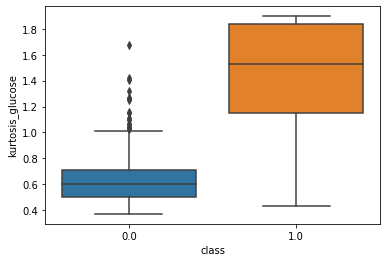

In [8]:
rule1(data_train,"train_rule1")

AxesSubplot(0.125,0.125;0.775x0.755)

Total:  1303
TP 289
TN 950
FP 9
FN 55
accuracy: (TP + TN) / total population =  0.9508825786646201
precision: TP / (FP + TP) =  0.9697986577181208
recall: TP / (FN + TP) =  0.8401162790697675
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       959
           1       0.97      0.84      0.90       344

    accuracy                           0.95      1303
   macro avg       0.96      0.92      0.93      1303
weighted avg       0.95      0.95      0.95      1303



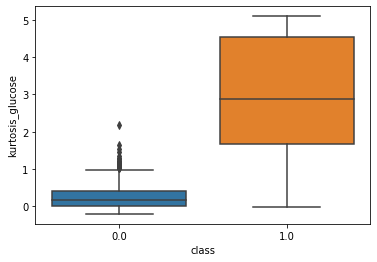

In [9]:
rule1(data_valid,"valid_rule1")

### **Pravidlo #2: (komplikovanejšie zahŕňajúce viacero atribútov)**
Ak je hodnota atributu skewness_glucose nad 2 a hodnota kurtosis_oxygen je mensia ako 9 tak bude patrit do triedy 1, cize je pacient pravdepodobne chory

In [10]:
def rule2(data, key):
	sns.scatterplot(y="skewness_glucose", x="kurtosis_oxygen", hue="class", data=data)

	temp = data[data['class'].notna()]

	rules[key] = dict()
	rules[key]["total"] = temp['class'].count()
	rules[key]["tp"] = len(
		temp.loc[((temp.skewness_glucose > 2) & (temp.kurtosis_oxygen < 9)) & (temp['class'] == 1.0), 'class'])
	rules[key]["tn"] = len(temp.loc[((temp.skewness_glucose <= 2) | (temp.kurtosis_oxygen >= 9)) & (
			temp['class'] == 0.0), 'class'])
	rules[key]["fp"] = len(
		temp.loc[((temp.skewness_glucose > 2) & (temp.kurtosis_oxygen < 9)) & (temp['class'] == 0.0), 'class'])
	rules[key]["fn"] = len(temp.loc[((temp.skewness_glucose <= 2) | (temp.kurtosis_oxygen >= 9)) & (
			temp['class'] == 1.0), 'class'])

	calculate_metrics(rules, key)

	rules[key]["values"] = np.array((temp.apply(
		lambda row: 1.0 if ((row.skewness_glucose > 2) and (row.kurtosis_oxygen < 9)) else 0.0,
		axis=1)).values.tolist())
	rules[key]["cr"] = classification_report(temp['class'], rules[key]["values"], target_names=["0", "1"])
	print(rules[key]["cr"])


Total:  3925
TP 657
TN 2920
FP 3
FN 345
accuracy: (TP + TN) / total population =  0.9113375796178343
precision: TP / (FP + TP) =  0.9954545454545455
recall: TP / (FN + TP) =  0.655688622754491
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      2923
           1       1.00      0.66      0.79      1002

    accuracy                           0.91      3925
   macro avg       0.94      0.83      0.87      3925
weighted avg       0.92      0.91      0.90      3925



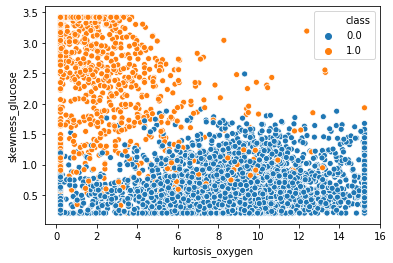

In [11]:
rule2(data_train,"train_rule2")


Total:  1303
TP 252
TN 954
FP 5
FN 92
accuracy: (TP + TN) / total population =  0.9255564082885649
precision: TP / (FP + TP) =  0.980544747081712
recall: TP / (FN + TP) =  0.7325581395348837
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       959
           1       0.98      0.73      0.84       344

    accuracy                           0.93      1303
   macro avg       0.95      0.86      0.90      1303
weighted avg       0.93      0.93      0.92      1303



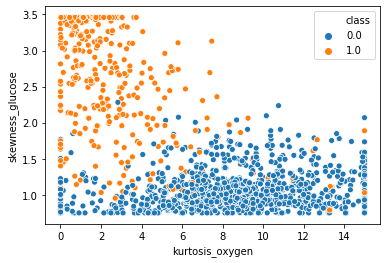

In [12]:
rule2(data_valid,"valid_rule2")

## Natrénovanie a vyhodnotenie klasifikátora s využitím rozhodovacích stromov

In [13]:
data_train = data_train.dropna()
train_labels = data_train['class']

data_valid = data_valid.dropna()
valid_labels = data_valid['class']

In [14]:
columns = ['name','address','date_of_birth','class']

df_train_class = data_train.drop(columns, axis=1)
df_train_class = pd.get_dummies(df_train_class) 

df_valid_class = data_valid.drop(columns, axis=1)
df_valid_class = pd.get_dummies(df_valid_class) 


missing_cols = set( df_train_class.columns ) - set( df_valid_class.columns )

for c in missing_cols:
    df_valid_class[c] = 0

df_valid_class = df_valid_class[df_train_class.columns]

In [15]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(df_train_class, train_labels)

In [16]:
predicted_labels = clf.predict(df_valid_class)
basic_acc = metrics.accuracy_score(valid_labels, predicted_labels)
basic_acc

0.9378357636224098

In [17]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file =None, 
                                feature_names=df_valid_class.columns,
                                class_names = ["1","0"], 
                                filled = True,
                                rounded = True,
                               )
graph = graphviz.Source(dot_data)
graph.render("strom")

'strom.pdf'

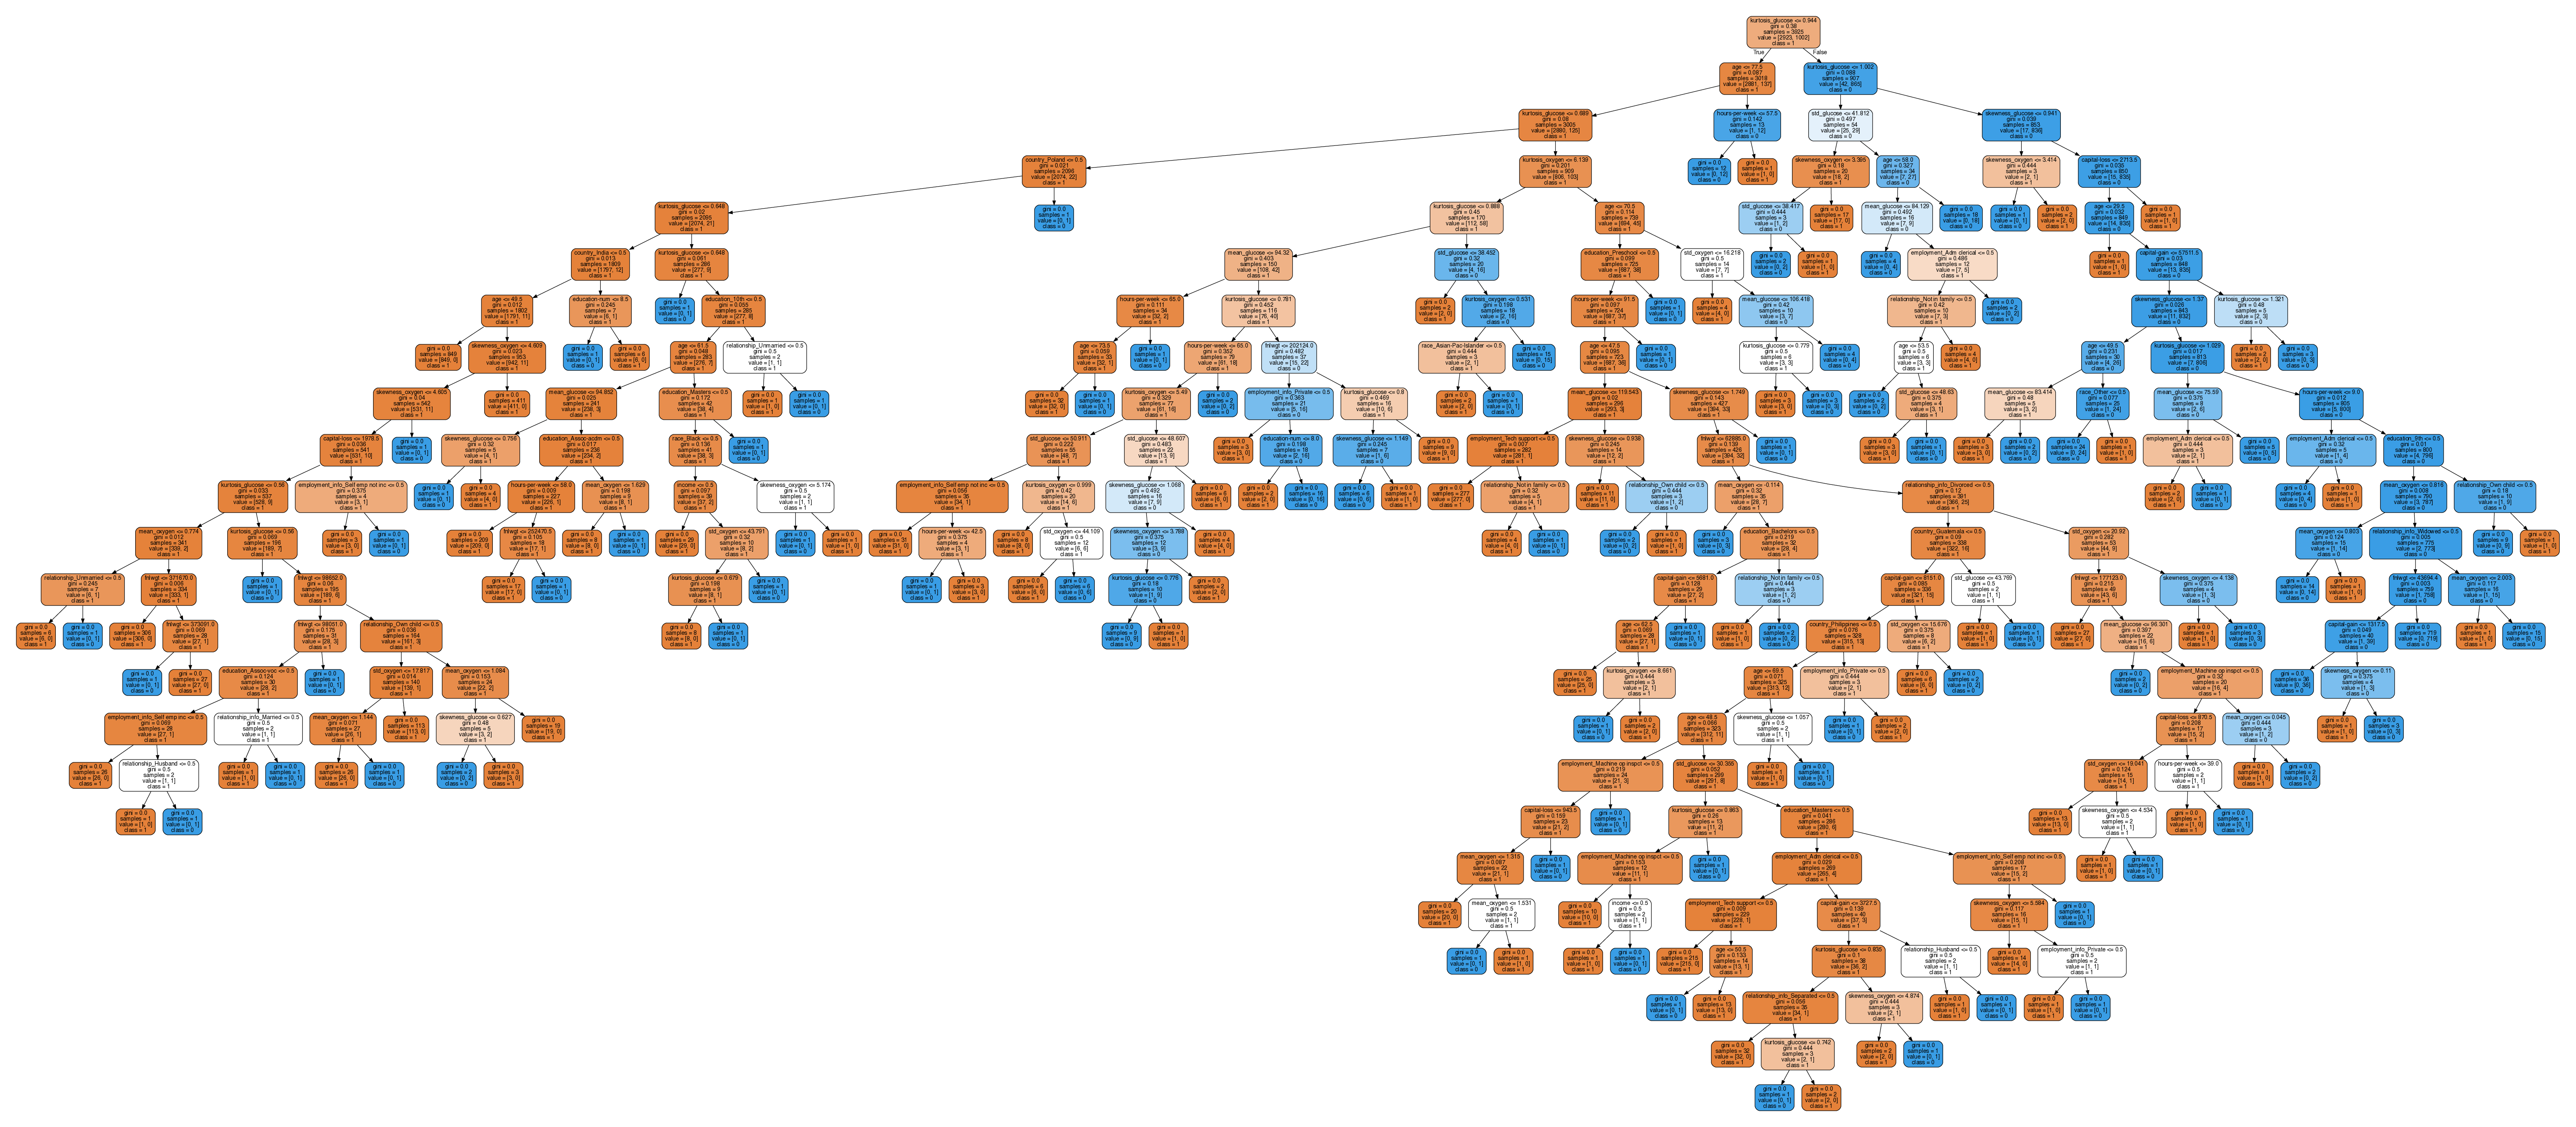

In [18]:
from wand.image import Image as WImage
img_strom = WImage(filename='strom.pdf')
img_strom

#### Vyhodnotenie klasifikatora

In [19]:
print(classification_report(valid_labels, predicted_labels, target_names = ["0","1"]))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       959
           1       0.87      0.90      0.88       344

    accuracy                           0.94      1303
   macro avg       0.92      0.93      0.92      1303
weighted avg       0.94      0.94      0.94      1303



In [20]:
from sklearn.metrics import confusion_matrix
confusion_matrix(valid_labels, predicted_labels)

array([[911,  48],
       [ 33, 311]])

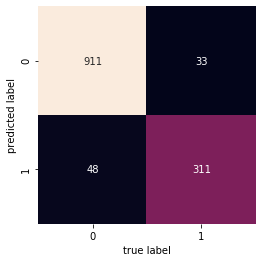

In [21]:
mat = confusion_matrix(valid_labels, predicted_labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

### Porovnanie natrénovaného klasifikátora s manuálne vytvorenými pravidlami z druhej časti

In [22]:
print("Metriky Pravidla 1 na validacnom datasete:\n\n",rules["valid_rule1"]["cr"])

Metriky Pravidla 1 na validacnom datasete:

               precision    recall  f1-score   support

           0       0.95      0.99      0.97       959
           1       0.97      0.84      0.90       344

    accuracy                           0.95      1303
   macro avg       0.96      0.92      0.93      1303
weighted avg       0.95      0.95      0.95      1303



In [23]:
print("Metriky Pravidla 2 na validacnom datasete:\n\n",rules["valid_rule2"]["cr"])

Metriky Pravidla 2 na validacnom datasete:

               precision    recall  f1-score   support

           0       0.91      0.99      0.95       959
           1       0.98      0.73      0.84       344

    accuracy                           0.93      1303
   macro avg       0.95      0.86      0.90      1303
weighted avg       0.93      0.93      0.92      1303



In [24]:
print("Metriky klasifikacie pomocou rozhodovacieho stromu\n\n",classification_report(valid_labels, predicted_labels, target_names = ["0","1"]))

Metriky klasifikacie pomocou rozhodovacieho stromu

               precision    recall  f1-score   support

           0       0.97      0.95      0.96       959
           1       0.87      0.90      0.88       344

    accuracy                           0.94      1303
   macro avg       0.92      0.93      0.92      1303
weighted avg       0.94      0.94      0.94      1303



## Optimalizácia hyperparametrov

In [25]:
%%capture --no-display
parameters = {'criterion': ('gini','entropy'), 'splitter': ('best','random'), 'max_depth': range(2,20), 'max_features':range(1,77,5)}
# 10-nasobna cross validacia
optimization = GridSearchCV(clf, parameters,cv=10)
vysledok = optimization.fit(df_train_class, train_labels)
vysledok

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ('gini', 'entropy'),
                         'max_depth': range(2, 20),
                        

In [26]:
params = optimization.best_params_

In [27]:
	clf = tree.DecisionTreeClassifier(
		criterion=params['criterion'],
		max_depth=params['max_depth'],
		max_features=params['max_features'],
		splitter=params['splitter'])

In [28]:
clf = tree.DecisionTreeClassifier(criterion='gini', max_depth=4, max_features=61, splitter='best')
clf = clf.fit(df_train_class, train_labels)

In [29]:
predicted_labels = clf.predict(df_valid_class)
basic_acc = metrics.accuracy_score(valid_labels, predicted_labels)
basic_acc

0.9562547966231773

In [30]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file =None, 
                                feature_names=df_train_class.columns,
                                class_names = ["1","0"], 
                                filled = True,
                                rounded = True,
                               )
graph = graphviz.Source(dot_data)
graph.render("strom2")

'strom2.pdf'

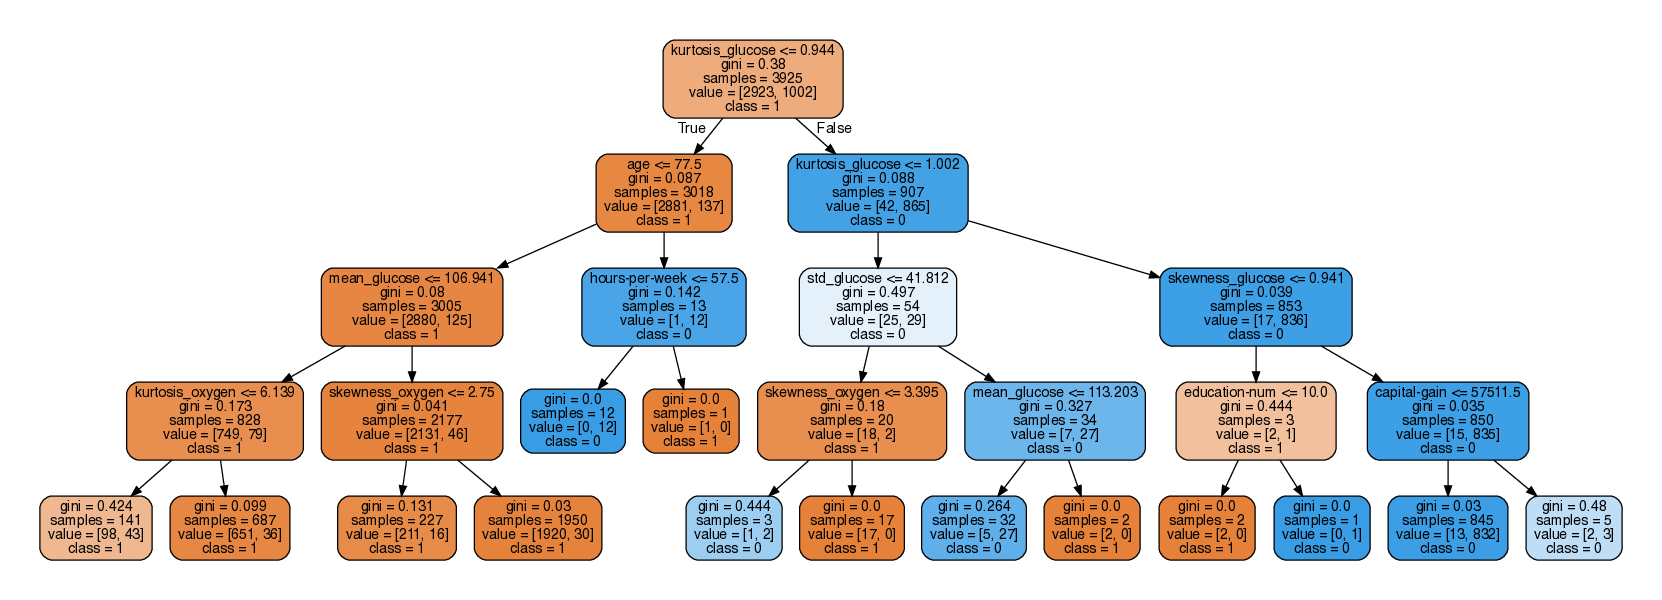

In [31]:
img_strom2 = WImage(filename='strom2.pdf')
img_strom2

In [32]:
print(classification_report(valid_labels, predicted_labels, target_names = ["0","1"]))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       959
           1       0.93      0.90      0.92       344

    accuracy                           0.96      1303
   macro avg       0.95      0.94      0.94      1303
weighted avg       0.96      0.96      0.96      1303



Vyskusali sme hladat v hyperparametroch

- criterion: funkcia na zmeranie kvality rozdelenia
- splitter: strategia pouzita na zvolenie splitu na kazdej node
- max_depth: maximalna hlbka stromu
- max_features: pocet atributov ktore berie do uvahy pri hladani najlepsieho rozdelenia

## Vyhodnotenie vplyvu zvolenej stratégie riešenia chýbajúcich hodnôt na správnosť klasifikácie 

In [33]:
%run "functions.py"

<Figure size 432x288 with 0 Axes>

In [34]:
datastore = dict()

In [35]:
def repair_data_with_strategy(filename,strategy):
    
    data_personal = load("data/personal_"+filename+".csv")
    data_other = load("data/other_"+filename+".csv")
    data = pd.merge(data_personal,data_other,on=['name','address'], how = 'outer')
    
    functions = [
        sanitize_sex,
        sanitize_pregnancy,
        sanitize_personal_info,
        sanitize_age_of_birth,
        sanitize_age,
        sanitize_income,
        sanitize_string_attrs,
        deduplicate,
        fill_null_age_by_mean,
        fill_education_values,
        fill_employment_values,
        fill_pregnancy,
        fill_relationship_info,
        resolve_outliers,
    ]
        
    for fn in functions:
        data = fn(data,datastore)
        
    if strategy == "mean":
        columns = [
            "kurtosis_oxygen",
            "education-num",
            "skewness_glucose",
            "mean_glucose",
            "std_oxygen",
            'capital-loss', 
            'std_glucose',
            'fnlwgt', 
            'kurtosis_glucose', 
            'skewness_oxygen',   
            'capital-gain', 
            'mean_oxygen',
            'hours-per-week',
        ]
        data = fill_columns_with_mean(data,datastore,columns)
   
    elif strategy == "freq":

        columns = [
             "kurtosis_oxygen",
            "education-num",
            "skewness_glucose",
            "mean_glucose",
            "std_oxygen",
            'capital-loss', 
            'std_glucose',
            'fnlwgt', 
            'kurtosis_glucose', 
            'skewness_oxygen',   
            'capital-gain', 
            'mean_oxygen',
            'hours-per-week',
        ]
        data = fill_columns_with_freq(data,datastore,columns)
    
    # zvysne hodnoty ktore este maju nan tak nahradime (tych je minimum)
    data = fill_mean_or_most_freq(data,datastore)
    return data

In [36]:
%%capture --no-display
for strategy in ["mean","freq"]:
    datastore[strategy] = dict()
    for dataset in ["train","valid"]:
        datastore[strategy][dataset] = repair_data_with_strategy(dataset,strategy)
    create_stromcek(datastore[strategy],strategy)
    

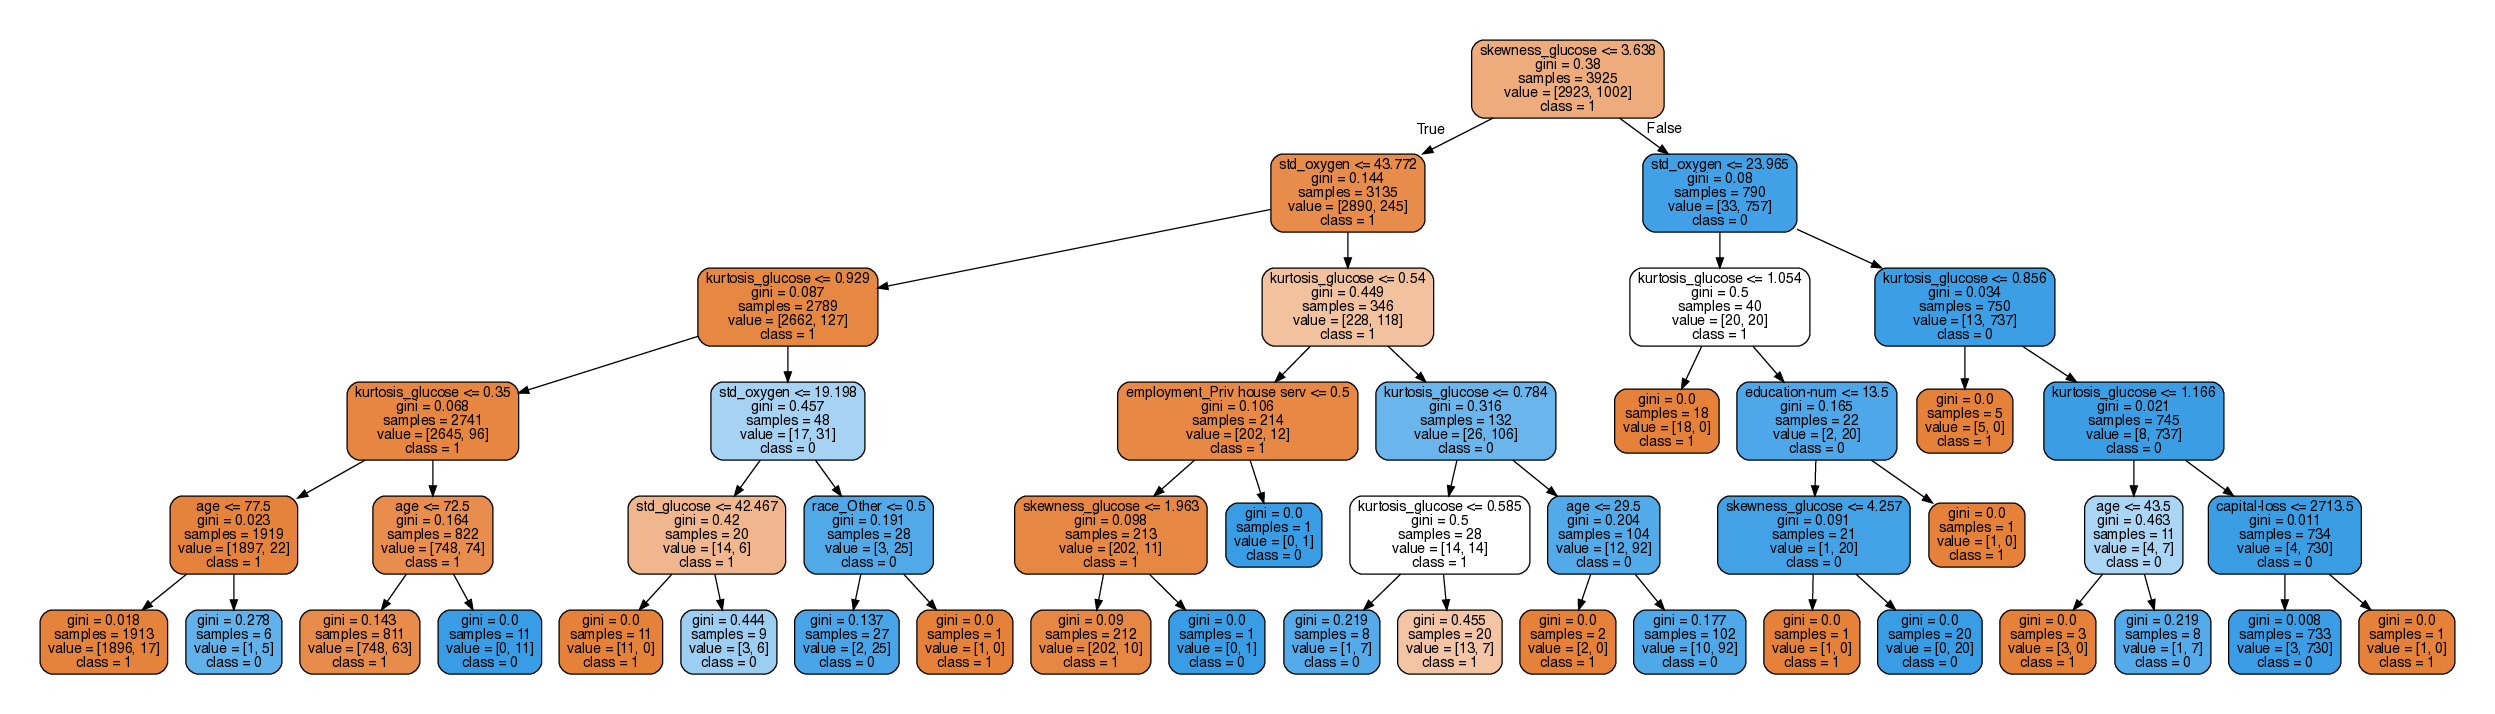

In [37]:
WImage(filename='strom_mean.pdf')

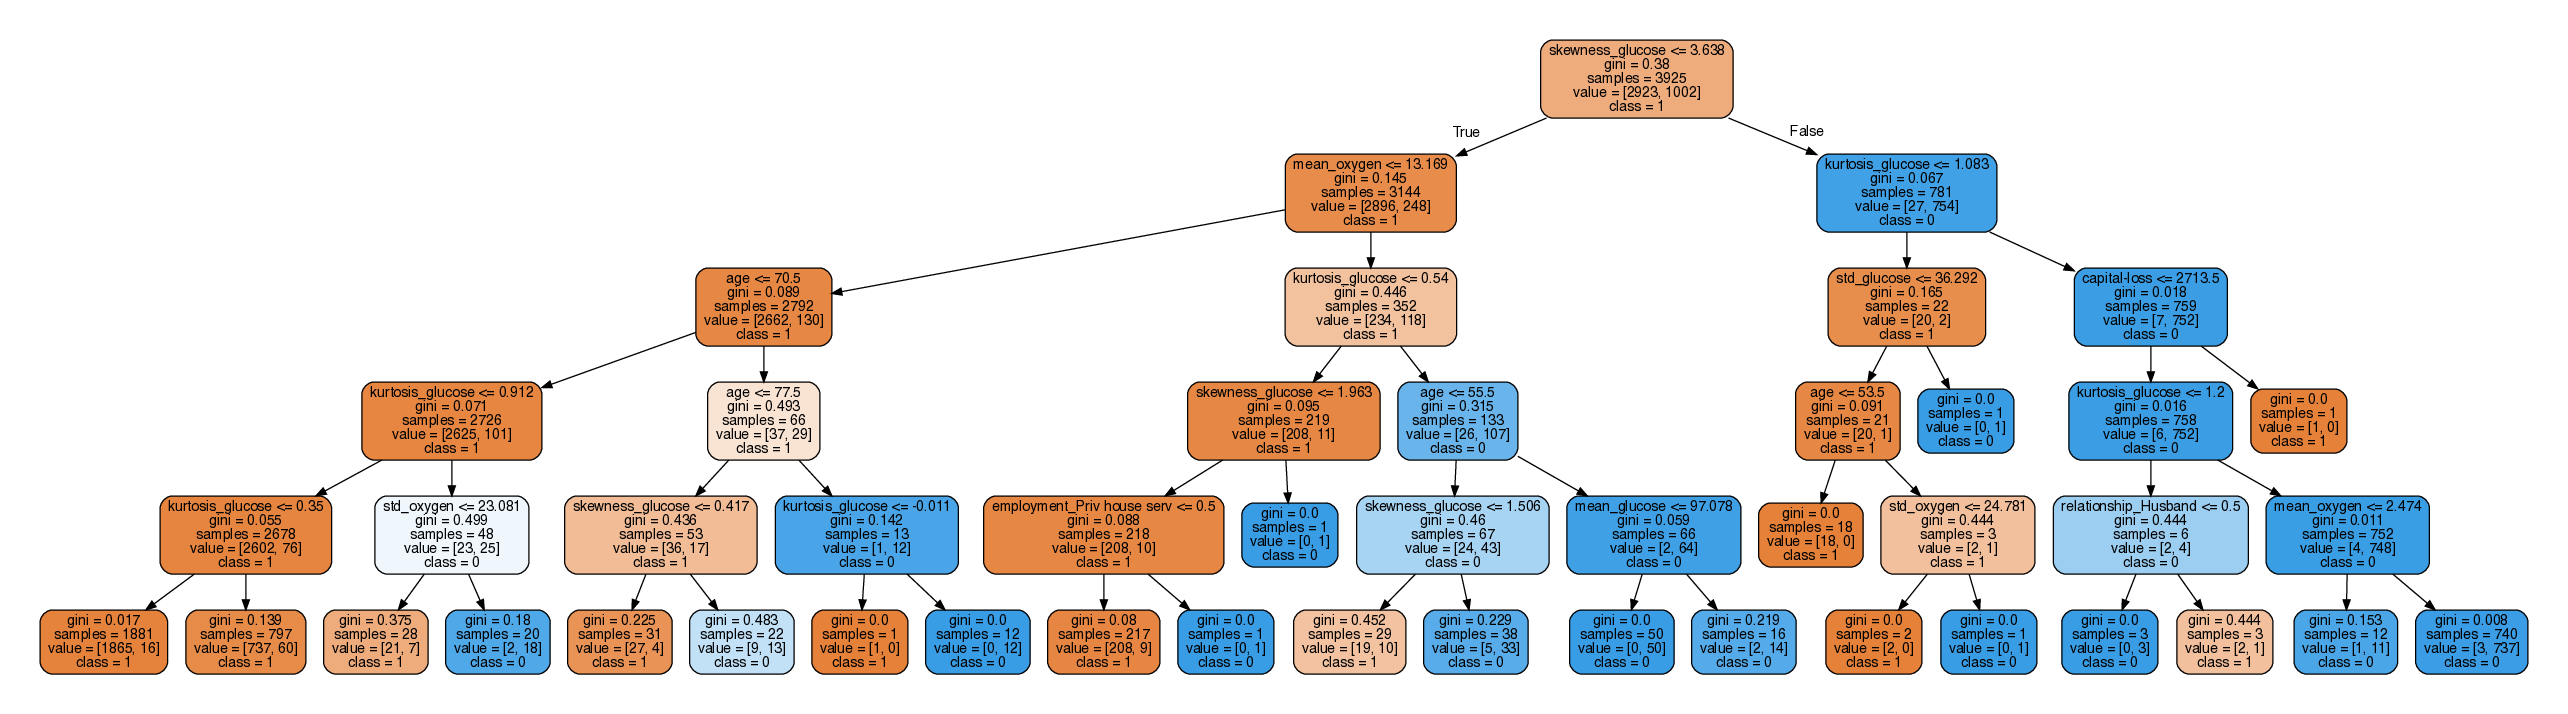

In [38]:
WImage(filename='strom_freq.pdf')